In [144]:
#DAILY PERCENTAGE RETURNS DATA... need this to see how the price reacts to a given news release
# Remember, we are just doing the daily percentage gains, not going intraday yet, to keep things simple.

#Let's set up our Alpaca API...

# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import hvplot.pandas
%matplotlib inline



In [145]:
# Load .env environment variables
load_dotenv()

True

In [146]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Verify that Alpaca key and secret were correctly loaded without compromising security
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [147]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [148]:
# Create our timeframe: Jan 1, 2022 - Dec 31, 2022
# Format date as ISO format
start_date = pd.Timestamp("2022-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2022-12-31", tz="America/New_York").isoformat()

In [149]:
# We need to get the tickers for all stocks in the S&P 500
# Going to get the symbols of the stocks contained in the S&P 500 from the dataframe created in "DataCleaning.ipynb"

# Load in libraries needed to read the csv
import pandas as pd
from pathlib import Path

# Defining Paths
snp500_path = Path("../Group3Project1/Resources/constituents.csv")

# Reading CSV
snp500_data = pd.read_csv(snp500_path, index_col="Symbol")

# Sort data in alphabetical order. We will keep this consistient among the datasets we create.
snp500_data.sort_index(inplace=True)

# Preview Data
display(snp500_data.head())
display(snp500_data.tail())

,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
Symbol,,,,,,,
A,Agilent Technologies,Health Care,Health Care Equipment,"Santa Clara, California",2000-06-05,1090872,1999
AAL,American Airlines Group,Industrials,Passenger Airlines,"Fort Worth, Texas",2015-03-23,6201,1934
AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977
ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ABNB,Airbnb,Consumer Discretionary,"Hotels, Resorts & Cruise Lines","San Francisco, California",2023-09-18,1559720,2008


,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
Symbol,,,,,,,
YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873
ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",2013-06-21,1555280,1952


In [150]:
# Our goal here is to capture the "Symbol" column of the snp500 dataframe.

# Reset the index so that we have Symbol as a normal column. Save the result of that operation with "inplace=True".
snp500_data.reset_index(inplace=True)

# Preview data.
snp500_data.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,A,Agilent Technologies,Health Care,Health Care Equipment,"Santa Clara, California",2000-06-05,1090872,1999
1,AAL,American Airlines Group,Industrials,Passenger Airlines,"Fort Worth, Texas",2015-03-23,6201,1934
2,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABNB,Airbnb,Consumer Discretionary,"Hotels, Resorts & Cruise Lines","San Francisco, California",2023-09-18,1559720,2008


In [151]:
# Now we can capture the symbol column
snp500_symbols = snp500_data["Symbol"]

# Preview data.
display(snp500_symbols.head())
display(snp500_symbols.tail())

0       A
1     AAL
2    AAPL
3    ABBV
4    ABNB
Name: Symbol, dtype: object

498     YUM
499     ZBH
500    ZBRA
501    ZION
502     ZTS
Name: Symbol, dtype: object

NOTICE: Why do we have 503 rows? Isn't it the S&P *500*? 

Although the it is called the "S&P 500", it constitutes of 503 stocks.


In [152]:
# Now that we have an array of all symbols in the S&P 500, we want to use that list to get data for those tickers using Alpaca API


# Given the Alpaca API's protocal, we should set 'tickers' to all stocks in the S&P 500. 

# Need to include '[:]' or else the snp500_symbols will be set equal to "tickers"...
# which would be troublesome because we need to keep the snp500_symbols index the same for later use.
tickers = snp500_symbols[:]

# We want to increment the index by 1, because the Alpaca API starts taking in data starting at Index = 1... I THINK.. CHECK THIS!!
tickers.index = tickers.index+1

display(tickers.head())

print('Origional')
display(snp500_symbols.head())

1       A
2     AAL
3    AAPL
4    ABBV
5    ABNB
Name: Symbol, dtype: object

Origional


0       A
1     AAL
2    AAPL
3    ABBV
4    ABNB
Name: Symbol, dtype: object

In [153]:
# Notice that the above indicies are begin at 1 and 0, respectively, which is good.

In [154]:
# We are fousing on daily returns.
# Set timeframe to one day ("1Day") for the Alpaca API.
timeframe = "1Day"

# Get daily closing prices for year 2022 of all stocks in S&P 500.
snp500_price_df = alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# Display sample data
snp500_price_df.head()


,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2022-01-03 05:00:00+00:00,18.75,19.1800,18.2000,162182,18.230,44860486,18.777172,AAL
2022-01-04 05:00:00+00:00,19.02,19.4600,18.8504,119441,19.215,30433127,19.089447,AAL
2022-01-05 05:00:00+00:00,18.68,19.3850,18.5100,133200,19.130,35253129,18.917920,AAL
2022-01-06 05:00:00+00:00,18.57,19.0599,18.3500,91484,18.890,19726860,18.669406,AAL
2022-01-07 05:00:00+00:00,19.28,19.5900,18.5800,158007,18.750,43826540,19.210886,AAL


Notice how the above took 19 seconds to run and spit out and output. That is quite a long time if you are trying to employ a stock trading strategy that requires lighting fast connection. This 19 seconds is a limitation to those such strategies, especially when considering that the S&P return data from 2022 is old and not that BIG in terms of data. We would like to see things like the orders being placed, going through, options activity, and many more technical signals... quickly. Potentially there could be ways to improve the code itself to improve the speed of it.

 Now, we will have to find some work arounds. These can include: faster internet connection, faster API,  more specific data, steaming it?, ext..

In [155]:
# Notice that above the first symbol listed is "AAL", however, we need "A" to be first, as that is the order of our initial symbol list.

# Let's play around with the index so that we can properely sort our new DF.

# Reset the index
snp500_price_df = snp500_price_df.reset_index()

display(snp500_price_df.head())
display(snp500_price_df.tail())


,timestamp,close,high,low,trade_count,open,volume,vwap,symbol
0,2022-01-03 05:00:00+00:00,18.75,19.1800,18.2000,162182,18.230,44860486,18.777172,AAL
1,2022-01-04 05:00:00+00:00,19.02,19.4600,18.8504,119441,19.215,30433127,19.089447,AAL
2,2022-01-05 05:00:00+00:00,18.68,19.3850,18.5100,133200,19.130,35253129,18.917920,AAL
3,2022-01-06 05:00:00+00:00,18.57,19.0599,18.3500,91484,18.890,19726860,18.669406,AAL
4,2022-01-07 05:00:00+00:00,19.28,19.5900,18.5800,158007,18.750,43826540,19.210886,AAL


,timestamp,close,high,low,trade_count,open,volume,vwap,symbol
125422,2022-12-23 05:00:00+00:00,145.76,145.8920,143.5400,20025,144.51,1017604,145.236784,ZTS
125423,2022-12-27 05:00:00+00:00,145.30,146.1474,143.5700,19294,145.91,957871,145.322438,ZTS
125424,2022-12-28 05:00:00+00:00,143.83,146.6400,143.7700,19669,145.18,1443916,144.409503,ZTS
125425,2022-12-29 05:00:00+00:00,148.15,148.5100,145.1378,21072,145.20,1298851,147.959023,ZTS
125426,2022-12-30 05:00:00+00:00,146.55,147.7900,144.7400,22281,147.20,1249518,146.129091,ZTS


In [156]:
# Set the index to 'symbol' so we can sort alphabetically by 'symbol'
snp500_price_df = snp500_price_df.set_index('symbol')
display(snp500_price_df.head())
display(snp500_price_df.tail())

,timestamp,close,high,low,trade_count,open,volume,vwap
symbol,,,,,,,,
AAL,2022-01-03 05:00:00+00:00,18.75,19.1800,18.2000,162182,18.230,44860486,18.777172
AAL,2022-01-04 05:00:00+00:00,19.02,19.4600,18.8504,119441,19.215,30433127,19.089447
AAL,2022-01-05 05:00:00+00:00,18.68,19.3850,18.5100,133200,19.130,35253129,18.917920
AAL,2022-01-06 05:00:00+00:00,18.57,19.0599,18.3500,91484,18.890,19726860,18.669406
AAL,2022-01-07 05:00:00+00:00,19.28,19.5900,18.5800,158007,18.750,43826540,19.210886


,timestamp,close,high,low,trade_count,open,volume,vwap
symbol,,,,,,,,
ZTS,2022-12-23 05:00:00+00:00,145.76,145.8920,143.5400,20025,144.51,1017604,145.236784
ZTS,2022-12-27 05:00:00+00:00,145.30,146.1474,143.5700,19294,145.91,957871,145.322438
ZTS,2022-12-28 05:00:00+00:00,143.83,146.6400,143.7700,19669,145.18,1443916,144.409503
ZTS,2022-12-29 05:00:00+00:00,148.15,148.5100,145.1378,21072,145.20,1298851,147.959023
ZTS,2022-12-30 05:00:00+00:00,146.55,147.7900,144.7400,22281,147.20,1249518,146.129091


In [157]:
# Now sort index alphabetically, ascending is the default. 
snp500_price_df = snp500_price_df.sort_index()
display(snp500_price_df.head())
display(snp500_price_df.tail())

,timestamp,close,high,low,trade_count,open,volume,vwap
symbol,,,,,,,,
A,2022-01-03 05:00:00+00:00,156.48,159.440,153.930,24320,159.00,1855491,155.916852
A,2022-08-23 04:00:00+00:00,132.64,134.105,132.044,22511,133.11,1312701,132.799144
A,2022-08-24 04:00:00+00:00,133.67,134.540,132.650,19162,133.02,1171108,133.682537
A,2022-08-25 04:00:00+00:00,136.01,136.080,133.990,18936,135.30,1082407,135.147622
A,2022-08-26 04:00:00+00:00,129.87,136.050,129.780,23682,136.00,1439050,131.184323


,timestamp,close,high,low,trade_count,open,volume,vwap
symbol,,,,,,,,
ZTS,2022-05-10 04:00:00+00:00,162.65,164.75,159.08,53452,163.99,3141027,161.982615
ZTS,2022-05-11 04:00:00+00:00,159.90,164.11,159.26,46055,161.87,4239464,160.763873
ZTS,2022-05-12 04:00:00+00:00,163.08,163.68,158.27,41201,158.34,2672868,162.002346
ZTS,2022-04-25 04:00:00+00:00,180.30,181.11,176.44,39876,180.69,2384476,178.997726
ZTS,2022-12-30 05:00:00+00:00,146.55,147.79,144.74,22281,147.20,1249518,146.129091


In [158]:
# We see above that we are now sorted correctly.


# Now we want to reset the index, so we recreate 'timestamp' as the index.
snp500_price_df = snp500_price_df.reset_index()


In [159]:
# Ensure the reset is proper.
snp500_price_df

,symbol,timestamp,close,high,low,trade_count,open,volume,vwap
0,A,2022-01-03 05:00:00+00:00,156.48,159.440,153.930,24320,159.00,1855491,155.916852
1,A,2022-08-23 04:00:00+00:00,132.64,134.105,132.044,22511,133.11,1312701,132.799144
2,A,2022-08-24 04:00:00+00:00,133.67,134.540,132.650,19162,133.02,1171108,133.682537
3,A,2022-08-25 04:00:00+00:00,136.01,136.080,133.990,18936,135.30,1082407,135.147622
4,A,2022-08-26 04:00:00+00:00,129.87,136.050,129.780,23682,136.00,1439050,131.184323
...,...,...,...,...,...,...,...,...,...
125422,ZTS,2022-05-10 04:00:00+00:00,162.65,164.750,159.080,53452,163.99,3141027,161.982615
125423,ZTS,2022-05-11 04:00:00+00:00,159.90,164.110,159.260,46055,161.87,4239464,160.763873
125424,ZTS,2022-05-12 04:00:00+00:00,163.08,163.680,158.270,41201,158.34,2672868,162.002346
125425,ZTS,2022-04-25 04:00:00+00:00,180.30,181.110,176.440,39876,180.69,2384476,178.997726


In [160]:
# Return 'timestamp' as the index.
snp500_price_df = snp500_price_df.set_index('timestamp')

In [161]:
# Now the df is properly sorted by 'symbol' and the 'timestamp' is the index again.
display(snp500_price_df.head())
display(snp500_price_df.tail())

,symbol,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,,
2022-01-03 05:00:00+00:00,A,156.48,159.440,153.930,24320,159.00,1855491,155.916852
2022-08-23 04:00:00+00:00,A,132.64,134.105,132.044,22511,133.11,1312701,132.799144
2022-08-24 04:00:00+00:00,A,133.67,134.540,132.650,19162,133.02,1171108,133.682537
2022-08-25 04:00:00+00:00,A,136.01,136.080,133.990,18936,135.30,1082407,135.147622
2022-08-26 04:00:00+00:00,A,129.87,136.050,129.780,23682,136.00,1439050,131.184323


,symbol,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,,
2022-05-10 04:00:00+00:00,ZTS,162.65,164.75,159.08,53452,163.99,3141027,161.982615
2022-05-11 04:00:00+00:00,ZTS,159.90,164.11,159.26,46055,161.87,4239464,160.763873
2022-05-12 04:00:00+00:00,ZTS,163.08,163.68,158.27,41201,158.34,2672868,162.002346
2022-04-25 04:00:00+00:00,ZTS,180.30,181.11,176.44,39876,180.69,2384476,178.997726
2022-12-30 05:00:00+00:00,ZTS,146.55,147.79,144.74,22281,147.20,1249518,146.129091


Now we need to reorganize the dataframe so that each symbol is its own dataframe.


In [162]:
# We will essentially be doing the following for each symbol...
A = snp500_price_df[snp500_price_df['symbol'] == 'A'].drop('symbol', axis=1)
ZTS = snp500_price_df[snp500_price_df['symbol'] == 'ZTS'].drop('symbol', axis=1)

# Then we concatenate those symbols, using the ticker as the key.
test_df_A_ZTS = pd.concat([A, ZTS], axis=1, keys=['A', 'ZTS'])

display(test_df_A_ZTS.head())

A                                      \
                            close    high     low trade_count    open   
timestamp                                                               
2022-01-03 05:00:00+00:00  156.48  159.44  153.93       24320  159.00   
2022-01-04 05:00:00+00:00  151.19  155.63  149.70       34709  155.49   
2022-01-05 05:00:00+00:00  148.60  153.10  148.53       27423  150.83   
2022-01-06 05:00:00+00:00  149.12  149.96  145.58       34443  148.85   
2022-01-07 05:00:00+00:00  145.15  149.73  145.09       28610  149.12   

                                                   ZTS                   \
                            volume        vwap   close    high      low   
timestamp                                                                 
2022-01-03 05:00:00+00:00  1855491  155.916852  234.03  243.24  233.320   
2022-01-04 05:00:00+00:00  2510184  151.522046  225.12  234.02  222.140   
2022-01-05 05:00:00+00:00  2966289  149.705613  216.56  227.00  215.600   
2022-01-06 05:00:00+00:00  2502203  148.493000  217.42  220.56  213.625   
2022-01-07 05:00:00+00:00  2415233  146.271401  211.09  217.42  210.780   

                                                                    
                          trade_count    open   volume        vwap  
timestamp                                                           
2022-01-03 05:00:00+00:00       40631  242.29  3110633  234.902990  
2022-01-04 05:00:00+00:00       72176  234.02  5082693  225.646202  
2022-01-05 05:00:00+00:00       74079  227.00  5352738  218.720396  
2022-01-06 05:00:00+00:00       53574  215.48  3448961  217.727004  
2022-01-07 05:00:00+00:00       35901  217.13  2584840  212.467092

Let's go ahead and iterate this.

In [163]:
# First, create a list of symbols so that we can set the keys easily when creating the final df.
# Use the origional array of symbols we have above 'snp500_symbols'

# Create empty list.
snp500_symbols_list=[]

# Given length of our array 'snp500_symbols', add each element of that array to our new list, 'snp500_symbols_list'
for x in range(len(snp500_symbols)):
    snp500_symbols_list.append(snp500_symbols[x])

# Preview list and its length
display(snp500_symbols_list[:5])
display(snp500_symbols_list[-5:])
len(snp500_symbols_list)

['A', 'AAL', 'AAPL', 'ABBV', 'ABNB']

['YUM', 'ZBH', 'ZBRA', 'ZION', 'ZTS']

503

In [164]:
# Now that we have a list of symbols, lets start creating the new dataframe with each symbol having its own set of data.

snp500_2022_returns_df = pd.DataFrame()

# We will create a list of these dataframes for easier concatenation. 
df_list = []


# Make list of the dataframes. Each df is the data associated with one symbol in our snp500_price_df

# For all elements('symbols') in 'snp500_symbols_list'...
for x in snp500_symbols_list:
    # Create a new element ('ticker_data_1'), which is a dataframe the data associated with one symbol.
    ticker_data_1 = snp500_price_df[snp500_price_df['symbol'] == x].drop('symbol', axis=1)
    # Add that element to our list of dataframes
    df_list.append(ticker_data_1)    

# Concat the list of dataframes. Set the keys of each df to the list of symbols that we created.
snp500_2022_returns_df = pd.concat(df_list, axis=1, keys=snp500_symbols_list)

In [165]:
# Preview dataframe
# I am including both ends of the data for the next step; double checking to see if first/last values align.
display(snp500_2022_returns_df.head())
display(snp500_2022_returns_df.tail())

A                                      \
                            close    high     low trade_count    open   
timestamp                                                               
2022-01-03 05:00:00+00:00  156.48  159.44  153.93       24320  159.00   
2022-01-04 05:00:00+00:00  151.19  155.63  149.70       34709  155.49   
2022-01-05 05:00:00+00:00  148.60  153.10  148.53       27423  150.83   
2022-01-06 05:00:00+00:00  149.12  149.96  145.58       34443  148.85   
2022-01-07 05:00:00+00:00  145.15  149.73  145.09       28610  149.12   

                                                  AAL                    ...  \
                            volume        vwap  close     high      low  ...   
timestamp                                                                ...   
2022-01-03 05:00:00+00:00  1855491  155.916852  18.75  19.1800  18.2000  ...   
2022-01-04 05:00:00+00:00  2510184  151.522046  19.02  19.4600  18.8504  ...   
2022-01-05 05:00:00+00:00  2966289  149.705613  18.68  19.3850  18.5100  ...   
2022-01-06 05:00:00+00:00  2502203  148.493000  18.57  19.0599  18.3500  ...   
2022-01-07 05:00:00+00:00  2415233  146.271401  19.28  19.5900  18.5800  ...   

                             ZION                         ZTS          \
                             open   volume       vwap   close    high   
timestamp                                                               
2022-01-03 05:00:00+00:00  63.880  1414361  64.236825  234.03  243.24   
2022-01-04 05:00:00+00:00  66.110  1557604  66.314555  225.12  234.02   
2022-01-05 05:00:00+00:00  66.465  1121305  66.574460  216.56  227.00   
2022-01-06 05:00:00+00:00  67.100  1660365  68.300571  217.42  220.56   
2022-01-07 05:00:00+00:00  69.180  1456668  69.918369  211.09  217.42   

                                                                             
                               low trade_count    open   volume        vwap  
timestamp                                                                    
2022-01-03 05:00:00+00:00  233.320       40631  242.29  3110633  234.902990  
2022-01-04 05:00:00+00:00  222.140       72176  234.02  5082693  225.646202  
2022-01-05 05:00:00+00:00  215.600       74079  227.00  5352738  218.720396  
2022-01-06 05:00:00+00:00  213.625       53574  215.48  3448961  217.727004  
2022-01-07 05:00:00+00:00  210.780       35901  217.13  2584840  212.467092  

[5 rows x 3521 columns]

A                                              \
                            close    high     low trade_count    open  volume   
timestamp                                                                       
2022-12-23 05:00:00+00:00  149.23  150.25  148.22       17530  149.01  779426   
2022-12-27 05:00:00+00:00  149.55  149.81  147.30       17148  149.23  879543   
2022-12-28 05:00:00+00:00  148.09  151.37  147.64       19078  149.78  784312   
2022-12-29 05:00:00+00:00  151.09  151.90  149.02       17820  149.61  854392   
2022-12-30 05:00:00+00:00  149.65  149.85  147.83       15040  149.76  699759   

                                         AAL                   ...   ZION  \
                                 vwap  close    high      low  ...   open   
timestamp                                                      ...          
2022-12-23 05:00:00+00:00  149.203604  12.71  12.710  12.3298  ...  48.28   
2022-12-27 05:00:00+00:00  149.313607  12.53  12.790  12.3950  ...  48.65   
2022-12-28 05:00:00+00:00  148.753919  12.32  12.680  12.2500  ...  48.87   
2022-12-29 05:00:00+00:00  151.121691  12.70  12.710  12.2950  ...  48.06   
2022-12-30 05:00:00+00:00  149.211086  12.72  12.825  12.5300  ...  48.61   

                                                  ZTS                      \
                            volume       vwap   close      high       low   
timestamp                                                                   
2022-12-23 05:00:00+00:00  1354480  48.435983  145.76  145.8920  143.5400   
2022-12-27 05:00:00+00:00   795675  48.808658  145.30  146.1474  143.5700   
2022-12-28 05:00:00+00:00   776919  48.189316  143.83  146.6400  143.7700   
2022-12-29 05:00:00+00:00   789947  48.992500  148.15  148.5100  145.1378   
2022-12-30 05:00:00+00:00   710112  49.092991  146.55  147.7900  144.7400   

                                                                    
                          trade_count    open   volume        vwap  
timestamp                                                           
2022-12-23 05:00:00+00:00       20025  144.51  1017604  145.236784  
2022-12-27 05:00:00+00:00       19294  145.91   957871  145.322438  
2022-12-28 05:00:00+00:00       19669  145.18  1443916  144.409503  
2022-12-29 05:00:00+00:00       21072  145.20  1298851  147.959023  
2022-12-30 05:00:00+00:00       22281  147.20  1249518  146.129091  

[5 rows x 3521 columns]

I want to manually check the data to ensure the first and last values align with each other.

In [166]:
# First and last tickers in the above dataframe
tickers = ['A', 'ZTS']

# Get daily closing prices for these test values. 
testing_df2 = alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# Display sample data
display(testing_df2.head())
display(testing_df2.tail())


,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2022-01-03 05:00:00+00:00,156.48,159.44,153.93,24320,159.00,1855491,155.916852,A
2022-01-04 05:00:00+00:00,151.19,155.63,149.70,34709,155.49,2510184,151.522046,A
2022-01-05 05:00:00+00:00,148.60,153.10,148.53,27423,150.83,2966289,149.705613,A
2022-01-06 05:00:00+00:00,149.12,149.96,145.58,34443,148.85,2502203,148.493000,A
2022-01-07 05:00:00+00:00,145.15,149.73,145.09,28610,149.12,2415233,146.271401,A


,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2022-12-23 05:00:00+00:00,145.76,145.8920,143.5400,20025,144.51,1017604,145.236784,ZTS
2022-12-27 05:00:00+00:00,145.30,146.1474,143.5700,19294,145.91,957871,145.322438,ZTS
2022-12-28 05:00:00+00:00,143.83,146.6400,143.7700,19669,145.18,1443916,144.409503,ZTS
2022-12-29 05:00:00+00:00,148.15,148.5100,145.1378,21072,145.20,1298851,147.959023,ZTS
2022-12-30 05:00:00+00:00,146.55,147.7900,144.7400,22281,147.20,1249518,146.129091,ZTS


Upon manual inspection, the values seem to align.

In [167]:
# Now capture the "close" column for each symbol's dataframe
# snp500_2022_returns_df["A"]["close"], but we will iterate


In [168]:
# Create dataframe for closing prices
snp500_close_df = pd.DataFrame()

# Im going to use the list of snp500 symbols I created above for this iteration and I am having trouble with multi-indexing

for col in snp500_symbols_list:
    snp500_close_df[col+ " close($)"] = snp500_2022_returns_df[col]['close']
    

/var/folders/tl/pmdc2_wx3hx1zkjc2fzswyyc0000gn/T/ipykernel_2007/4168162207.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  snp500_close_df[col+ " close($)"] = snp500_2022_returns_df[col]['close']
/var/folders/tl/pmdc2_wx3hx1zkjc2fzswyyc0000gn/T/ipykernel_2007/4168162207.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  snp500_close_df[col+ " close($)"] = snp500_2022_returns_df[col]['close']
/var/folders/tl/pmdc2_wx3hx1zkjc2fzswyyc0000gn/T/ipykernel_2007/4168162207.py:7: PerformanceWarning: DataFrame is highly fragmented.  

In [169]:
snp500_close_df.head()

,A close($),AAL close($),AAPL close($),ABBV close($),ABNB close($),ABT close($),ACGL close($),ACN close($),ADBE close($),ADI close($),...,WYNN close($),XEL close($),XOM close($),XRAY close($),XYL close($),YUM close($),ZBH close($),ZBRA close($),ZION close($),ZTS close($)
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-03 05:00:00+00:00,156.48,18.75,182.01,135.42,172.68,139.04,44.55,407.21,564.37,177.15,...,87.77,67.94,63.54,56.89,116.89,136.53,129.13,583.90,64.24,234.03
2022-01-04 05:00:00+00:00,151.19,19.02,179.70,135.16,170.80,135.77,45.13,404.30,554.00,175.55,...,87.49,68.37,65.93,57.18,118.13,137.26,130.44,587.60,66.07,225.12
2022-01-05 05:00:00+00:00,148.60,18.68,174.92,135.87,162.25,135.16,44.60,397.18,514.43,172.84,...,84.25,69.04,66.75,56.26,116.52,135.52,130.01,558.18,66.22,216.56
2022-01-06 05:00:00+00:00,149.12,18.57,172.00,135.23,159.75,135.14,44.86,378.00,514.12,173.39,...,84.64,68.50,68.32,56.22,116.36,136.92,128.93,555.16,68.94,217.42
2022-01-07 05:00:00+00:00,145.15,19.28,172.17,134.88,166.05,135.56,45.07,370.75,510.70,168.84,...,84.55,69.10,68.88,56.40,115.43,135.35,128.15,530.86,70.09,211.09


<Axes: xlabel='timestamp'>

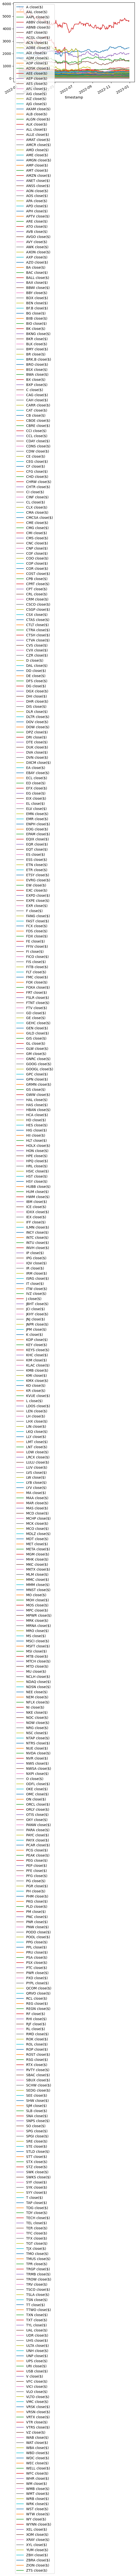

In [170]:
# Lets plot 
# NEED TO CONFIGURE THIS... HOW DO WE WANT TO GROUP THE COMPANIES HERE?
# Not going to be able to show 503 lines on one chart... haha
snp500_close_df.plot()

In [171]:
# Use that "close" column to generate daily percent returns over the entirety of 2022.

# Drop the time component of the date or we will get an error
snp500_close_df.index = snp500_close_df.index.date
snp500_close_df.head()


,A close($),AAL close($),AAPL close($),ABBV close($),ABNB close($),ABT close($),ACGL close($),ACN close($),ADBE close($),ADI close($),...,WYNN close($),XEL close($),XOM close($),XRAY close($),XYL close($),YUM close($),ZBH close($),ZBRA close($),ZION close($),ZTS close($)
2022-01-03,156.48,18.75,182.01,135.42,172.68,139.04,44.55,407.21,564.37,177.15,...,87.77,67.94,63.54,56.89,116.89,136.53,129.13,583.90,64.24,234.03
2022-01-04,151.19,19.02,179.70,135.16,170.80,135.77,45.13,404.30,554.00,175.55,...,87.49,68.37,65.93,57.18,118.13,137.26,130.44,587.60,66.07,225.12
2022-01-05,148.60,18.68,174.92,135.87,162.25,135.16,44.60,397.18,514.43,172.84,...,84.25,69.04,66.75,56.26,116.52,135.52,130.01,558.18,66.22,216.56
2022-01-06,149.12,18.57,172.00,135.23,159.75,135.14,44.86,378.00,514.12,173.39,...,84.64,68.50,68.32,56.22,116.36,136.92,128.93,555.16,68.94,217.42
2022-01-07,145.15,19.28,172.17,134.88,166.05,135.56,45.07,370.75,510.70,168.84,...,84.55,69.10,68.88,56.40,115.43,135.35,128.15,530.86,70.09,211.09


In [172]:
# Compute daily returns
snp500_2022_daily_returns_df = snp500_close_df.pct_change()#.dropna()

# Display sample data
snp500_2022_daily_returns_df.head()


,A close($),AAL close($),AAPL close($),ABBV close($),ABNB close($),ABT close($),ACGL close($),ACN close($),ADBE close($),ADI close($),...,WYNN close($),XEL close($),XOM close($),XRAY close($),XYL close($),YUM close($),ZBH close($),ZBRA close($),ZION close($),ZTS close($)
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,-0.033806,0.014400,-0.012692,-0.001920,-0.010887,-0.023518,0.013019,-0.007146,-0.018374,-0.009032,...,-0.003190,0.006329,0.037614,0.005098,0.010608,0.005347,0.010145,0.006337,0.028487,-0.038072
2022-01-05,-0.017131,-0.017876,-0.026600,0.005253,-0.050059,-0.004493,-0.011744,-0.017611,-0.071426,-0.015437,...,-0.037033,0.009800,0.012437,-0.016090,-0.013629,-0.012677,-0.003297,-0.050068,0.002270,-0.038024
2022-01-06,0.003499,-0.005889,-0.016693,-0.004710,-0.015408,-0.000148,0.005830,-0.048290,-0.000603,0.003182,...,0.004629,-0.007822,0.023521,-0.000711,-0.001373,0.010331,-0.008307,-0.005410,0.041075,0.003971
2022-01-07,-0.026623,0.038234,0.000988,-0.002588,0.039437,0.003108,0.004681,-0.019180,-0.006652,-0.026241,...,-0.001063,0.008759,0.008197,0.003202,-0.007992,-0.011467,-0.006050,-0.043771,0.016681,-0.029114


In [173]:
# snp500_2022_daily_returns_df.dropna(inplace=True)
# The above function drops all data for some reason.
# I can just drop the first row... but I want to make sure we don't have more NANs that we hidden. 


# Above did not work so I will simply delete the first row
snp500_2022_daily_returns_df = snp500_2022_daily_returns_df.drop(snp500_2022_daily_returns_df.index[0])
snp500_2022_daily_returns_df.head()


,A close($),AAL close($),AAPL close($),ABBV close($),ABNB close($),ABT close($),ACGL close($),ACN close($),ADBE close($),ADI close($),...,WYNN close($),XEL close($),XOM close($),XRAY close($),XYL close($),YUM close($),ZBH close($),ZBRA close($),ZION close($),ZTS close($)
2022-01-04,-0.033806,0.014400,-0.012692,-0.001920,-0.010887,-0.023518,0.013019,-0.007146,-0.018374,-0.009032,...,-0.003190,0.006329,0.037614,0.005098,0.010608,0.005347,0.010145,0.006337,0.028487,-0.038072
2022-01-05,-0.017131,-0.017876,-0.026600,0.005253,-0.050059,-0.004493,-0.011744,-0.017611,-0.071426,-0.015437,...,-0.037033,0.009800,0.012437,-0.016090,-0.013629,-0.012677,-0.003297,-0.050068,0.002270,-0.038024
2022-01-06,0.003499,-0.005889,-0.016693,-0.004710,-0.015408,-0.000148,0.005830,-0.048290,-0.000603,0.003182,...,0.004629,-0.007822,0.023521,-0.000711,-0.001373,0.010331,-0.008307,-0.005410,0.041075,0.003971
2022-01-07,-0.026623,0.038234,0.000988,-0.002588,0.039437,0.003108,0.004681,-0.019180,-0.006652,-0.026241,...,-0.001063,0.008759,0.008197,0.003202,-0.007992,-0.011467,-0.006050,-0.043771,0.016681,-0.029114
2022-01-10,0.000069,-0.025415,0.000116,0.011195,-0.032159,-0.002213,0.021078,0.006069,0.029626,0.009240,...,-0.028149,0.010999,-0.005952,-0.016844,-0.010136,-0.013964,-0.009754,0.008571,-0.007562,0.007153


<Axes: title={'center': 'All 503 Companies 2022 Daily Returns'}>

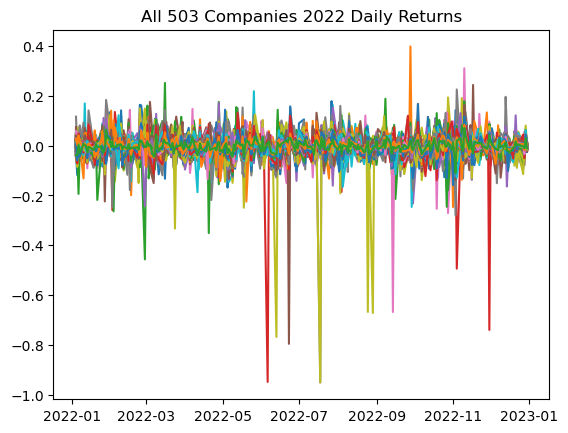

In [174]:
# Plot percent returns
snp500_2022_daily_returns_df.plot(legend=False, title='All 503 Companies 2022 Daily Returns')

Looks good. Now we need to categorize the price data by different variables to make the graph readable. It would be nice to zoom into the large wicks that we see and determine what happened on the days where that particular stock dropped or spiked up by that much.

It is very interesting to point out that it seems like the outliers to the downside were much more substantial than those upward. From looking at the graph we can count at least 7 stocks showing instances of daily returns below -0.6 = -60%, while we can see about 3 ticks above +0.2 = +20%. This idea seems to correlate with the fact that we can see an overall downtrend in the cumulative returns in the S&P 500 over the 2022 year. This is what we will dig into next.


Next, we will create a dataframe consisting of daily returns for the 503 stocks as group. So we will take the average of each row; the average of each 503 stock's return given the date. 

In [175]:
# Lets get the mean of the returns for the snp and plot the line on a graph.
# We get the average of all of them for one day.
# Do that for each day.
# Plot all of the days.

# Just going to use a for loop with counter to iterate row-wise
count = 0

# Save each output as a list, which we will use to create a column in the snp500_2022_daily_returns_df
avg_daily_snp500_returns_list = []

for x in range (len(snp500_2022_daily_returns_df)):
    # 'count' is going down row by row and taking the mean of all columns in that row.
    row_avg = snp500_2022_daily_returns_df.iloc[count].mean()
    avg_daily_snp500_returns_list.append(row_avg)
    count+=1

# Show a few returns in the list
avg_daily_snp500_returns_list[:5]

[0.007542135557411606,
 -0.016419760110538355,
 0.002428365316491533,
 -0.0030374529590554505,
 -0.0044319345618365185]

In [176]:
# Create a new column with the average daily returns list. We'll add that column to the snp500_returns df
snp500_2022_daily_returns_df["503 Stock AVG"] = avg_daily_snp500_returns_list

/var/folders/tl/pmdc2_wx3hx1zkjc2fzswyyc0000gn/T/ipykernel_2007/2506741610.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  snp500_2022_daily_returns_df["503 Stock AVG"] = avg_daily_snp500_returns_list


In [177]:
# We can verify that the column was added as the new last column of the dataframe.

last_3_columns = snp500_2022_daily_returns_df.iloc[:, -3:]
print(last_3_columns)


            ZION close($)  ZTS close($)  503 Stock AVG
2022-01-04       0.028487     -0.038072       0.007542
2022-01-05       0.002270     -0.038024      -0.016420
2022-01-06       0.041075      0.003971       0.002428
2022-01-07       0.016681     -0.029114      -0.003037
2022-01-10      -0.007562      0.007153      -0.004432
...                   ...           ...            ...
2022-12-23       0.003521      0.005033       0.006773
2022-12-27       0.008050     -0.003156      -0.000105
2022-12-28      -0.017813     -0.010117      -0.013737
2022-12-29       0.023139      0.030035       0.017412
2022-12-30       0.001630     -0.010800      -0.004145

[250 rows x 3 columns]


In [178]:
# Drop nan

In [179]:
# Let's save this df as as .csv file for later data analysis
snp500_2022_returns_path = '../Group3Project1/Resources/snp500_2022_returns.csv'
snp500_2022_daily_returns_df.to_csv(snp500_2022_returns_path, index=True)

In [180]:
# Now, let's plot the average daily returns of the snp500 companies for the 2022 year.
# snp500_2022_daily_returns_df["AVG of previous columns"].plot(kind='bar') 
avg_returns_visualization = snp500_2022_daily_returns_df["AVG of previous columns"].hvplot(title="S&P average daily returns 2022").opts(
)
avg_returns_visualization

KeyError: 'AVG of previous columns'

In [ ]:
# Lets see the cumulative returns

# Create the new data frame for cumulative returns
cuml_return_df = pd.DataFrame()

new_cuml_return = (1 + snp500_2022_daily_returns_df["AVG of previous columns"]).cumprod() 
cuml_return_df = pd.concat([cuml_return_df, new_cuml_return], axis=1)

display(cuml_return_df.head())

,AVG of previous columns
2022-01-03,NaN
2022-01-04,1.007542
2022-01-05,0.990999
2022-01-06,0.993405
2022-01-07,0.990388


In [ ]:


# Plot cumulative returns
new_plot1 = cuml_return_df['AVG of previous columns'].hvplot( title=' S&P500 2022 Cumulative Returns') 
# new_plot1.xaxis.set_major_locator(MonthLocator())                            
# new_plot1.xaxis.set_major_formatter(DateFormatter("%b %Y"))               

new_plot1

:Curve   [index]   (AVG of previous columns)

Cross refrencing this plot with that of the SPY using Webull's trading platform, the price action seemed to match up.

The overall trend of 2022 is a down trend.
If you bought the market on January 1st and sold your position at the end of the year, you would have lost money.
If you bought the market on January 1st and sold at any point in the rest of the 2022 year, you would have been selling at a loss, as we can see the second peak in the market around April *almost* reached its highs, but failed to do so, and continued it's down trend.

Is there evidence that these large dumns in the market correlate to fundamental changes in the global/US economy?
Well...Monkey Pox was just starting to get talked about online on about May 6th, 2022.. Looks like the market sold off a little there as the 
    would could have been preparing for ANOTHER pandemic... It could also just be the down trend continuing.

How about the major sell off on about July 6th, 2022? Lets see if any major news catalysts came out then... Not seeing anything except what was already known in May... War in Ukraine, Monkey Pox. I would have to do deeper into the timeframes to see which news catalysts came out exactly when, and what the response was from the market. 

I have been trading the market when a large fundamental catalysts comes out, and I see how the WHOLE market can shift when major major breaking news catalysts come out such as the war in Ukraine.... or like what we saw in 2022 with COVID.


In [ ]:
# DATA VISUALIZATION 
# Plot the volume. 
# Create dataframe for volume
snp500_daily_volume_df = pd.DataFrame()

# Im going to use the list of snp500 symbols I created above for this iteration and I am having trouble with multi-indexing

for col in snp500_symbols_list:
    snp500_daily_volume_df[col+ " daily volume"] = snp500_2022_returns_df[col]['volume']
    


/var/folders/tl/pmdc2_wx3hx1zkjc2fzswyyc0000gn/T/ipykernel_2007/1631739219.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  snp500_daily_volume_df[col+ " daily volume"] = snp500_2022_returns_df[col]['volume']
/var/folders/tl/pmdc2_wx3hx1zkjc2fzswyyc0000gn/T/ipykernel_2007/1631739219.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  snp500_daily_volume_df[col+ " daily volume"] = snp500_2022_returns_df[col]['volume']
/var/folders/tl/pmdc2_wx3hx1zkjc2fzswyyc0000gn/T/ipykernel_2007/1631739219.py:9: PerformanceWarning: DataFrame

In [ ]:
snp500_daily_volume_df.head()

,A daily volume,AAL daily volume,AAPL daily volume,ABBV daily volume,ABNB daily volume,ABT daily volume,ACGL daily volume,ACN daily volume,ADBE daily volume,ADI daily volume,...,WYNN daily volume,XEL daily volume,XOM daily volume,XRAY daily volume,XYL daily volume,YUM daily volume,ZBH daily volume,ZBRA daily volume,ZION daily volume,ZTS daily volume
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-03 05:00:00+00:00,1855491,44860486,112486091,7692127,4512974,7607428,1742987,2463982,3173009,3096258,...,2605540,3974437,27105217,1481496,889642,1569047,1279446,328029,1414361,3110633
2022-01-04 05:00:00+00:00,2510184,30433127,106090378,7142389,4336491,9598461,1157304,2780553,4658855,4242220,...,2393151,4917368,42200487,1757549,1087021,1140447,1510260,408021,1557604,5082693
2022-01-05 05:00:00+00:00,2966289,35253129,95142198,9179431,5052025,6994270,1242284,2822765,7486104,3668699,...,3461897,4643726,37270971,1503214,1393852,1162641,2025129,408267,1121305,5352738
2022-01-06 05:00:00+00:00,2502203,19726860,103899632,5340018,5455172,6439944,1831125,4773224,4213054,4121146,...,2670323,2638982,34353397,2191212,807541,984470,1154627,379376,1660365,3448961
2022-01-07 05:00:00+00:00,2415233,43826540,94554334,9709511,5844064,5169668,2132089,3911080,3997197,7335819,...,1897635,3162728,26816477,1414544,927247,986845,1859905,478130,1456668,2584840


In [ ]:
# Just going to use a for loop with counter to iterate row-wise
count = 0

# Save each output as a list, which we 
avg_daily_snp500_volume_list = []

for x in range (len(snp500_2022_daily_returns_df)):
    row_avg = snp500_daily_volume_df.iloc[count].mean()
    row_avg = int(row_avg)
    avg_daily_snp500_volume_list.append(row_avg)
    count+=1


avg_daily_snp500_volume_list[:5]

[4884938, 6162187, 5963520, 5207359, 5176845]

In [ ]:
# Add that list to our snp500_daily_volume_df
snp500_daily_volume_df["Average Daily Volume"] = avg_daily_snp500_volume_list

In [ ]:
snp500_daily_volume_df.head()

,A daily volume,AAL daily volume,AAPL daily volume,ABBV daily volume,ABNB daily volume,ABT daily volume,ACGL daily volume,ACN daily volume,ADBE daily volume,ADI daily volume,...,XEL daily volume,XOM daily volume,XRAY daily volume,XYL daily volume,YUM daily volume,ZBH daily volume,ZBRA daily volume,ZION daily volume,ZTS daily volume,Average Daily Volume
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-03 05:00:00+00:00,1855491,44860486,112486091,7692127,4512974,7607428,1742987,2463982,3173009,3096258,...,3974437,27105217,1481496,889642,1569047,1279446,328029,1414361,3110633,4884938
2022-01-04 05:00:00+00:00,2510184,30433127,106090378,7142389,4336491,9598461,1157304,2780553,4658855,4242220,...,4917368,42200487,1757549,1087021,1140447,1510260,408021,1557604,5082693,6162187
2022-01-05 05:00:00+00:00,2966289,35253129,95142198,9179431,5052025,6994270,1242284,2822765,7486104,3668699,...,4643726,37270971,1503214,1393852,1162641,2025129,408267,1121305,5352738,5963520
2022-01-06 05:00:00+00:00,2502203,19726860,103899632,5340018,5455172,6439944,1831125,4773224,4213054,4121146,...,2638982,34353397,2191212,807541,984470,1154627,379376,1660365,3448961,5207359
2022-01-07 05:00:00+00:00,2415233,43826540,94554334,9709511,5844064,5169668,2132089,3911080,3997197,7335819,...,3162728,26816477,1414544,927247,986845,1859905,478130,1456668,2584840,5176845


In [ ]:
# Plot the average daily volume for the S&P 500 stocks over 2022
snp500_daily_volume_df['Average Daily Volume'].hvplot.bar().opts(
    xlabel = 'Date',
    title = "Average Daily Volume for S&P 500 over 2022",
    ylabel = 'Daily Volume (Shares Traded)'
)

:Bars   [timestamp]   (Average Daily Volume)

Wow look at those spikes in volume. I wonder what those days relate to...

The first spike is March 18, 2022.
Then May 31.
Then June 17.
Then June 24.
Then September 16. 
Then September 30.
Then November 30.
Then December 16.

There are days where we had significantly less volume than average:
March 8th. November 25th. 

Other than these outliers, there does not seem to be an apparent trend in volume. It goes up and down almost like it is oscilating... So maybe we can describe the trend as showing somewhat of a sinusoidal movement.  

I feel like these spikes correlate to some kind of fundamental events. I would have to do some digging to see what people were saying on the days of both abnormally large and small volume to see if there was possible to correlation between the sentiment of the market and the volume shown on that given day.

NEXT: 
- clean up graphs
- Start data analysis
- Create csv for dfs
- Check in with group
- Decide who is going to talk about what
- Start shared PowerPoint

- Check in with Adrian about geoplot using the snp returns as parameter.
- Have to sort the returns by sector
- Sort the returns by population of the city where the company is located.

- Does our project currently meet all of the requirements?

In [ ]:
# DATA ANALYSIS
# Plot Returns versus sector
# Plot returns versus population of location
# Plot 
